<font size="6">Variational Inference - Discovering Latent States</font>

<font size="5">Purpose</font>

One of the difficulties in dealing with financial time series data is that there are many time-varying parameters, and the distributions are not stationary. Clustering approaches may be used to discover where these parameters are varying, and give us some idea of the overall stability/instability of those time-varying parameters. 

If models are built with any assumptions about the parameters of the data, and those parameters shift, then the model assumptions are invalidated and that model will fail. Mixture models based on EM (expectation-maximization) partition the data into states where the covariance matrix and mean of the parameters within each state differ significantly. A nice feature of the Dirichlet process mixture model is that is it both a clustering and generative model from which we can generate new samples based on the fitted posterior distribution. 

<font size="5">Method</font>

Using variational inference applied to time series data, the algorithm non-parametrically chooses a likely number of clusters (latent states) each with distinct <b>mean and covariance</b> parameters allowing computation of a likelihood function for the 3-dimensional point at any time step. The model optimizes the parameters of the clusters to maximize the likelihood of those parameters given the data. 

In order to define what it means to be a good approximation the Kullback-Leibler divergence (KL divergence) is a non-symmetric measure of the difference between two probability distributions 𝑃 and 𝑄. This comes from information theory -- entropy is the average amount of information or "surprise" in the divergence between the distributions. 

$\large D_{KL}(P \parallel Q) = \sum_{i} P(i) \log \frac{P(i)}{Q(i)}$

In the mean-field approximation, we also assume that the latent states will be partitioned so that each partition is independent. Using KL divergence, we can derive mutually dependent equations (one for each partition) that defines 𝑄 to approximate the posterior distribution. This is done for ease of computation for the iterative approach (expectation-maximization). Borrowing from Physics, in a system with many components that interact, those system interactions are replaced with a single average interaction (a "mean field"). 

The states' mean/covariances factorize, 

$\large q(\boldsymbol{\theta}) \approx \prod_{i=1}^n q(\theta_i)$

$\large q(\boldsymbol{\mu}, \boldsymbol{\Sigma}) \approx \prod_{i=1}^n q(\mu_i) q(\Sigma_i)$

One <b>shortcoming</b> of this approach, which is shown in another notebook is that the model does not preserve auto-correlation between the samples, which is expected. Thus, a different approach will be needed to introduce auto-correlation structure into synthetic data (such as fractional gaussian noise which will be covered in another notebook). 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

import sklearn 
import sklearn.mixture as mix 

I will be testing with a small universe of the 10Y Treasury ETF, a Commodity basket ETF, and Tech sector ETF using data from the <b>M6 Financial Forecasting</b> (https://m6competition.com/) competition sponsored by Google and others. The goal will be time series clustering using variational inference. There are re-occurring pockets of time (regimes, or repeating latent states) where certain assets outperform the others and their precise relationship is captured by the distribution mean and covariance within that cluster assignment. 

Set num_components to a very high number since the data is fit in a non-parametric way where we need not know the number of clusters in advance. 

In [2]:
assetlist = [ 'IEF', 'GSG', 'IXN' ]
num_components = 99

Create the subset of assets. We end up with a 3-dimensional multivariate gaussian system. 

In [3]:
m6 = pd.read_csv('./data/assets_m6_2022.csv')
m6_assets = pd.DataFrame()

for sym in assetlist: 
    m6_assets[sym] = m6[m6['symbol'] == sym]['price'].values

<font size="5">Lebesgue Integral & Auto-Correlation Decay Plots</font>

Formatting the training data. There is only training data and no test data in this exercise (it is a purely descriptive exercise). 1st-order differencing of the 15-day rolling mean log price for each asset. This is tracking a rolling integral within a bounded moving window and how much the area under the curve bounded between 'a' and 'b' shifts at each time step. Per the mean value theorem the integral and mean are identical here. 

$\large \int_a^b f(x) \, \mathrm{d}x$

There are regions where the mean is shifting in some significant way and this formatting of the data preserves long memory based on looking at the auto-correlation decay plots. The ACF function is defined as follows, 

$ \large \operatorname{ACF}(\tau) = \frac{\sum_{t=1}^{n-\tau} (x_t - \bar{x})(x_{t+\tau} - \bar{x})}{\sum_{t=1}^n (x_t - \bar{x})^2} $

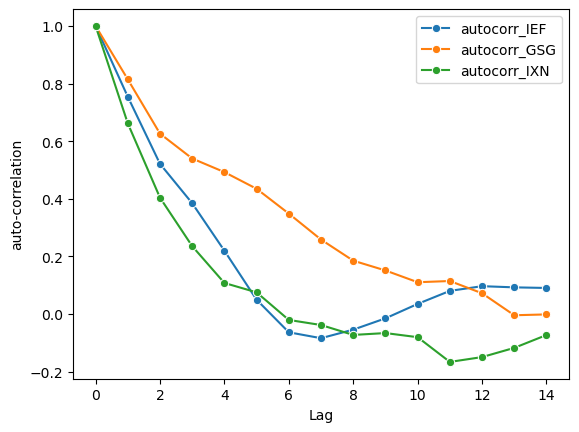

In [4]:
import scipy.stats as stats
m6_subset = m6_assets.copy()

# Window length 15 days
wlen = 15

# First convert to log price and produce rolling mean window
m6_subset = m6_subset.apply(np.log).rolling(wlen).mean()

# Then apply final 1st-order differencing to get a rate-of-change
m6_subset = m6_subset.apply(np.diff).dropna().reset_index().drop(columns='index')

# Apply z-score to make the series mean-reverting and standardize variance 
m6_subset['IEF'] = stats.zscore(m6_subset['IEF'])
m6_subset['GSG'] = stats.zscore(m6_subset['GSG'])
m6_subset['IXN'] = stats.zscore(m6_subset['IXN'])

# View Auto Correlation
decay_func = lambda S, _range: [S.apply(abs).autocorr(lag=Lag) for Lag in _range]
sns.lineplot(data=decay_func(m6_subset['IEF'], range(0, wlen)), label='autocorr_IEF', marker='o') 
sns.lineplot(data=decay_func(m6_subset['GSG'], range(0, wlen)), label='autocorr_GSG', marker='o')
sns.lineplot(data=decay_func(m6_subset['IXN'], range(0, wlen)), label='autocorr_IXN', marker='o')
plt.xlabel('Lag')
plt.ylabel('auto-correlation')
plt.show()

Instantiate a non-parametric model using the dirichlet process and view the clustering results on the training data. The shaded regions on the plot represent the most frequently occuring latent state discovered using np.argmax(). 

In [5]:
dpgmm_model = mix.BayesianGaussianMixture(n_components=num_components, 
                                          weight_concentration_prior_type='dirichlet_process', 
                                          n_init=10, 
                                          max_iter=1000000)

In [6]:
dpgmm_model.fit(m6_subset)
states = dpgmm_model.predict(m6_subset)

state_counts = np.zeros(num_components)
for M in states:
  state_counts[M] += 1 

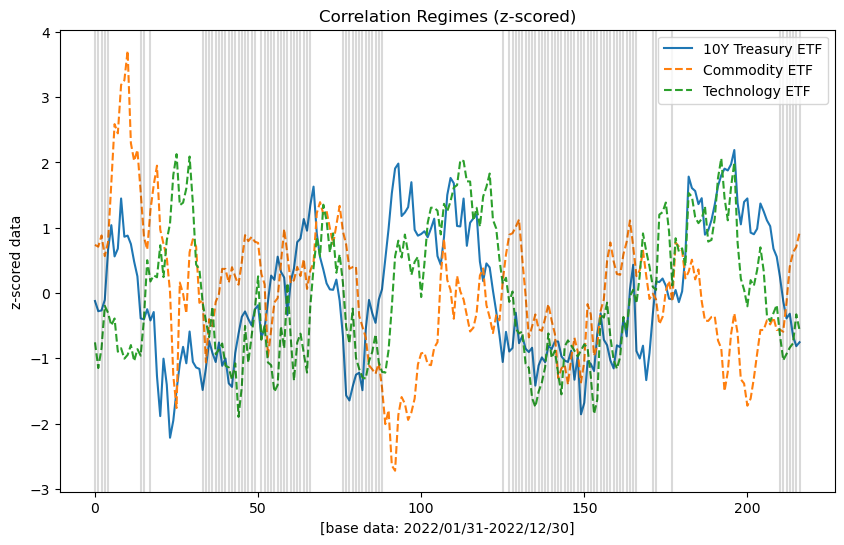

state_counts=
[105.   0.  63.  37.  12.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]


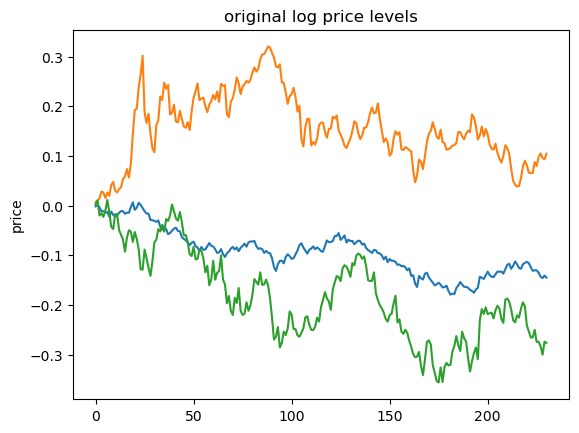

In [7]:
fig,ax = plt.subplots(figsize=(10, 6
                              ))
sns.lineplot(x=m6_subset.index, y=m6_subset['IEF'], ax=ax, label='10Y Treasury ETF')
sns.lineplot(x=m6_subset.index, y=m6_subset['GSG'], ax=ax, label='Commodity ETF', linestyle='--')
sns.lineplot(x=m6_subset.index, y=m6_subset['IXN'], ax=ax, label='Technology ETF', linestyle='--')

for M in range(len(states)): 
  if states[M] == np.argmax(state_counts):
    ax.axvline(M, color='black', alpha=0.15)

ax.set_title('Correlation Regimes (z-scored)')
ax.set_ylabel('z-scored data')
ax.set_xlabel(f'[base data: 2022/01/31-2022/12/30]')
plt.show()

print('state_counts=')
print(state_counts)

sns.lineplot(data=m6_assets.copy().apply(np.log).apply(np.diff).cumsum()['IEF'])
sns.lineplot(data=m6_assets.copy().apply(np.log).apply(np.diff).cumsum()['GSG'])
sns.lineplot(data=m6_assets.copy().apply(np.log).apply(np.diff).cumsum()['IXN'])
plt.title('original log price levels')
plt.ylabel('price')
plt.show()

<font size=5> Correlation & Precision Matrices </font>

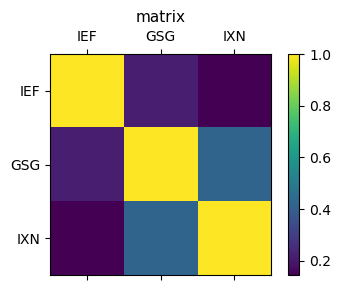

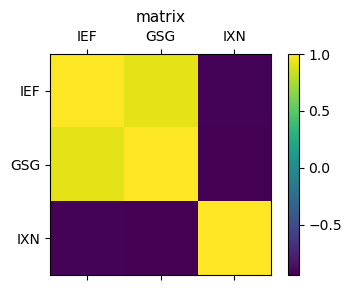

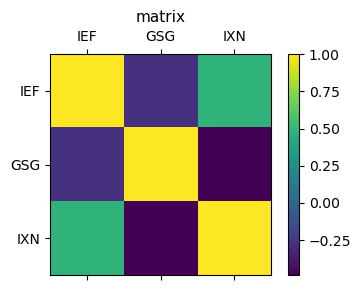

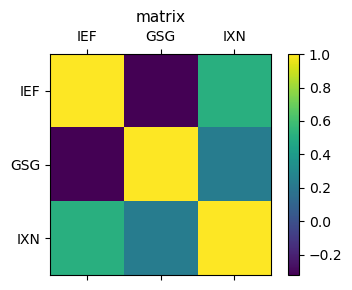

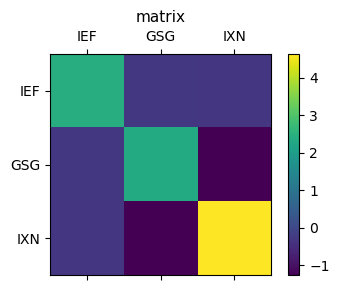

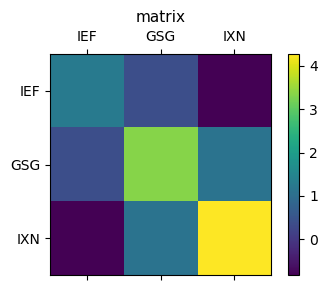

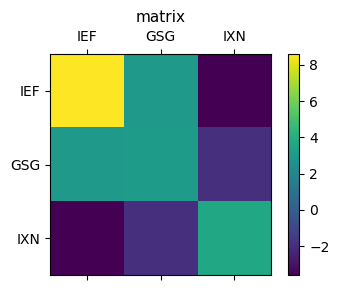

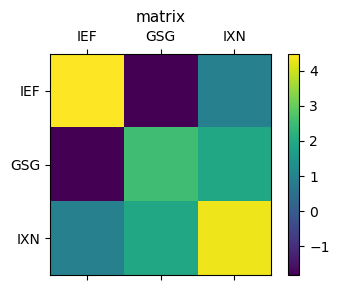

In [13]:
# Functions to draw correlation/precision matrix for a specific latent state 
def draw(matdata, matcols):
    
    matfig = plt.figure(figsize=(4, 3))
    matax = matfig.add_subplot()
    mat = matax.matshow(matdata)

    xaxis = np.arange(len(matcols))
    matax.set_xticks(xaxis)
    matax.set_yticks(xaxis) 
    matax.set_xticklabels(matcols)
    matax.set_yticklabels(matcols)

    matfig.colorbar(mat)
    plt.title(f'matrix', fontsize=11)
    plt.tight_layout()
    plt.show()
    
def draw_state(df, state_index): 
    matdata = df[df['state'] == state_index].drop(columns=['state'])
    matcols = df.columns.tolist()[:-1]
    draw(matdata.corr(), matcols)
    
def draw_precision(df, _p): 
    matdata = _p
    matcols = df.columns.tolist()[:-1]
    draw(matdata, matcols)
    
# Draw correlation matrix for each state, respectively 
m6_subset['state'] = states
for state in m6_subset['state'].unique(): 
    draw_state(m6_subset, state)
    
# Draw precision matrix for each state, respectively 
i=0
for precis in dpgmm_model.precisions_:
    if state_counts[i] > 0: 
        draw_precision(m6_subset, precis)
    i+=1